# Compute reference probability for RP55

The goal of this example is to present how we computed the reference probability for problem 55 of the BBRC. This calculation is based on the geometry of the failure domain. In order to compute its surface, we use the `shapely` module, which allows to compute the surface of bidimensional polygons.

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb
from shapely.geometry import Polygon

In [2]:
problem = otb.ReliabilityProblem55()

In [3]:
event = problem.getEvent()
g = event.getFunction()

In [4]:
problem.getProbability()

0.5600144282863704

## Compute the bounds of the domain

In [5]:
inputVector = event.getAntecedent()
distribution = inputVector.getDistribution()
X1 = distribution.getMarginal(0)
X2 = distribution.getMarginal(1)
alphaMin = 0.00001
alphaMax = 1 - alphaMin
lowerBound = ot.Point(
    [X1.computeQuantile(alphaMin)[0], X2.computeQuantile(alphaMin)[0]]
)
upperBound = ot.Point(
    [X1.computeQuantile(alphaMax)[0], X2.computeQuantile(alphaMax)[0]]
)

## Print the iso-values of the distribution

In [6]:
sampleSize = 5000
sampleInput = inputVector.getSample(sampleSize)
sampleOutput = g(sampleInput)
drawEvent = otb.DrawEvent(event)

In [7]:
cloud = drawEvent.drawSampleCrossCut(sampleSize)

## Draw the limit state surface

In [8]:
bounds = ot.Interval(lowerBound, upperBound)
bounds

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[-0.99998,-0.99998] upper bound=class=Point name=Unnamed dimension=2 values=[0.99998,0.99998] finite lower bound=[1,1] finite upper bound=[1,1]

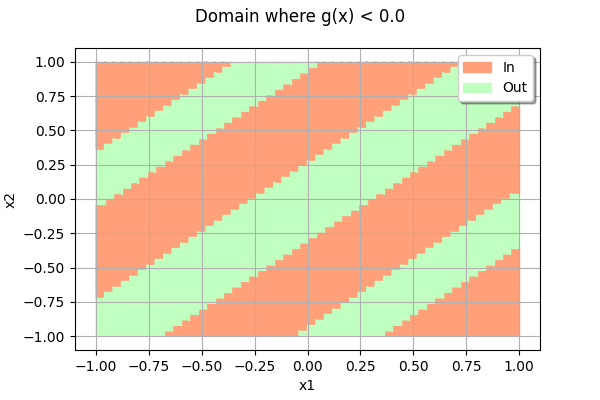

In [9]:
domain = drawEvent.fillEventCrossCut(bounds)
domain

## From integration

In [10]:
interval = ot.Interval([-1.0, -1.0], [1.0, 1.0])
interval

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[-1,-1] upper bound=class=Point name=Unnamed dimension=2 values=[1,1] finite lower bound=[1,1] finite upper bound=[1,1]

In [11]:
threshold = event.getThreshold()
threshold

0.0

In [12]:
mean = distribution.getMean()
mean

class=Point name=Unnamed dimension=2 values=[0,0]

In [13]:
def ComputeIntegrandPoint(x):
    """Evaluate the integrand on one single point."""
    y = g(x)
    if y[0] < threshold:
        indicator = 1.0
    else:
        indicator = 0.0
    pdf = distribution.computePDF(x)
    z = [indicator * pdf]
    return z


integrand = ot.PythonFunction(2, 1, ComputeIntegrandPoint)

In [14]:
integrand(mean)

class=Point name=Unnamed dimension=1 values=[0]

In [15]:
dimension = distribution.getDimension()
totalNumberOfPoints = 10 ** 4
numberOfPointsInX = int(totalNumberOfPoints ** (1.0 / dimension))
numberOfPointsInX

100

In [16]:
algoGL = ot.GaussLegendre([numberOfPointsInX] * dimension)
value = algoGL.integrate(integrand, interval)
value

class=Point name=Unnamed dimension=1 values=[0.558822]

In [17]:
def ComputeIntegrandSample(sample):
    """Evaluate the integrand on a sample."""
    indicatorBoolean = np.array(g(sample)) < threshold
    indicator = np.array(indicatorBoolean, float)
    pdf = np.array(distribution.computePDF(sample))
    z = indicator * pdf
    return z

In [18]:
integrandSample = ot.PythonFunction(2, 1, func_sample=ComputeIntegrandSample)

In [19]:
sample = distribution.getSample(5)
integrandSample(sample)

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[0.25],[0.25],[0.25],[0.25],[0.25]]

In [20]:
integrandSample(mean)

class=Point name=Unnamed dimension=1 values=[0]

In [21]:
dimension = distribution.getDimension()
totalNumberOfPoints = 10 ** 6
numberOfPointsInX = int(totalNumberOfPoints ** (1.0 / dimension))
numberOfPointsInX

1000

In [22]:
discretization = [numberOfPointsInX] * dimension
algoGL = ot.GaussLegendre(discretization)
value = algoGL.integrate(integrandSample, interval)
value

class=Point name=Unnamed dimension=1 values=[0.559983]

## Exact computation

We solve the exact equation:

https://www.wolframalpha.com/input/?i=solve+min%280.2+%2B+0.6+*+%28x+-+y%29%5E4+-+%28x+-+y%29+%2F+sqrt%282%29%2C+0.2+%2B+0.6+*+%28x+-+y%29%5E4+%2B+%28x+-+y%29+%2F+sqrt%282%29%2C+%28x+-+y%29+%2B+5+%2F+sqrt%282%29+-+2.2%2C+%28y+-+x%29+%2B+5+%2F+sqrt%282%29+-+2.2%29+%3D+0

```
solve (x - y) + 5 / sqrt(2) - 22/10 = 0
solve 2/10 + 6/10 * d^4 - d / sqrt(2)
```

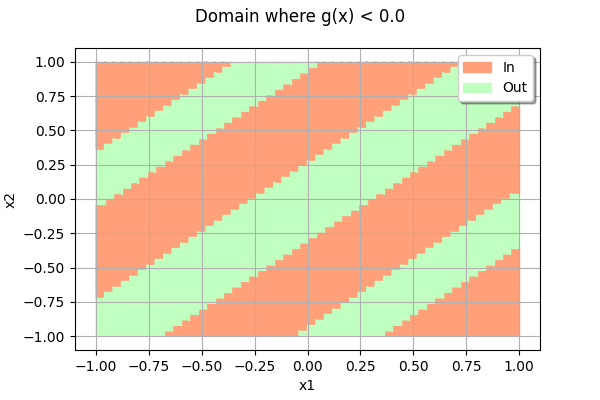

In [23]:
domain = drawEvent.fillEventCrossCut(bounds)
domain

We first compute the exact equations defining the slanted lines at the limit state.

In [24]:
palette = [
    "dodgerblue3",
    "darkorange1",
    "forestgreen",
    "firebrick3",
    "mediumpurple3",
    "lightsalmon4",
    "orchid",
    "gray50",
    "goldenrod3",
    "turquoise3",
]

The goal is to define the failure domain.

In [25]:
root1 = 5.0 / np.sqrt(2.0) - 2.2
root1

1.3355339059327371

In [26]:
root2 = 0.2887406174573670970
root2

0.2887406174573671

In [27]:
root3 = 0.9370483776955247344172976
root3

0.9370483776955247

In [28]:
root2 = 0.2887406174573670970
f1full = ot.SymbolicFunction(["x", "root2"], ["x-root2"])
f1 = ot.ParametricFunction(f1full, [1], [root2])
graph1 = f1.draw(root2 - 1.0, 1.0, 100)
graph1.setColors([palette[0]])
graph1.setLegends(["f1"])

In [29]:
f2full = ot.SymbolicFunction(["x", "root3"], ["x-root3"])
f2 = ot.ParametricFunction(f2full, [1], [root3])
graph2 = f2.draw(root3 - 1.0, 1.0, 100)
graph2.setColors([palette[1]])
graph2.setLegends(["f2"])

In [30]:
f3full = ot.SymbolicFunction(["x", "root1"], ["x-root1"])
f3 = ot.ParametricFunction(f3full, [1], [root1])
graph3 = f3.draw(root1 - 1.0, 1.0, 100)
graph3.setColors([palette[2]])
graph3.setLegends(["f3"])

In [31]:
f4full = ot.SymbolicFunction(["x", "root2"], ["x+root2"])
f4 = ot.ParametricFunction(f4full, [1], [root2])
graph4 = f4.draw(-1.0, 1.0 - root2, 100)
graph4.setColors([palette[3]])
graph4.setLegends(["f4"])

In [32]:
f5full = ot.SymbolicFunction(["x", "root3"], ["x+root3"])
f5 = ot.ParametricFunction(f5full, [1], [root3])
graph5 = f5.draw(-1.0, 1.0 - root3, 100)
graph5.setColors([palette[4]])
graph5.setLegends(["f5"])

In [33]:
f6full = ot.SymbolicFunction(["x", "root1"], ["x+root1"])
f6 = ot.ParametricFunction(f6full, [1], [root1])
graph6 = f6.draw(-1.0, 1.0 - root1, 100)
graph6.setColors([palette[5]])
graph6.setLegends(["f6"])

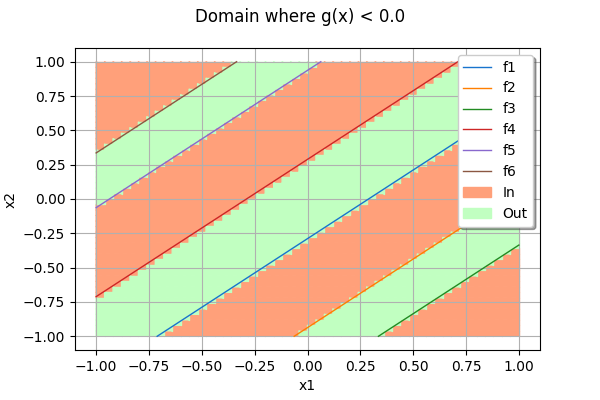

In [34]:
domain.add(graph1)
domain.add(graph2)
domain.add(graph3)
domain.add(graph4)
domain.add(graph5)
domain.add(graph6)
domain

Then we set the corners of the polygons in the failure domain.

In [35]:
data = [
    [-1.0, 1.0],
    [1.0, f1([1.0])[0]],
    [1.0, f2([1.0])[0]],
    [1.0, f3([1.0])[0]],
    [-1.0, f4([-1.0])[0]],
    [-1.0, f5([-1.0])[0]],
    [-1.0, f6([-1.0])[0]],
    [root1 - 1.0, -1.0],
    [root2 - 1.0, -1.0],
    [root3 - 1.0, -1.0],
    [1.0 - root1, 1.0],
    [1.0 - root2, 1.0],
    [1.0 - root3, 1.0],
    [1.0, -1.0],
]
sample = ot.Sample(data)
sample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=14 dimension=2 data=[[-1,1],[1,0.711259],[1,0.0629516],[1,-0.335534],[-1,-0.711259],[-1,-0.0629516],[-1,0.335534],[0.335534,-1],[-0.711259,-1],[-0.0629516,-1],[-0.335534,1],[0.711259,1],[0.0629516,1],[1,-1]]

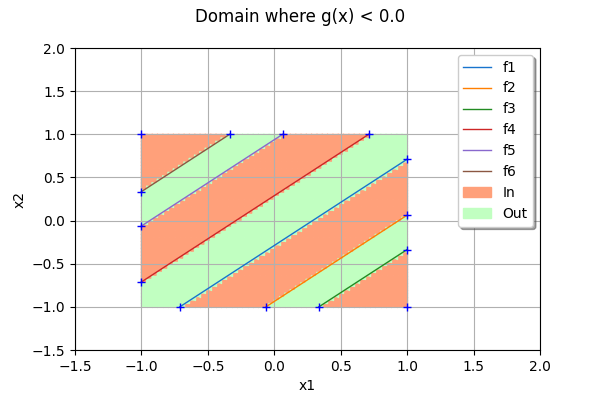

In [36]:
cloud = ot.Cloud(sample)
domain.add(cloud)
extendedBounds = ot.Interval([-1.5, -1.5], [2.0, 2.0])
domain.setBoundingBox(extendedBounds)
domain

In order to identify these points, we add the legends as text in the plot.

In [37]:
texts = ["p" + str(i) for i in range(sample.getSize())]
texts

['p0',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12',
 'p13']

In [38]:
text = ot.Text(sample, texts)

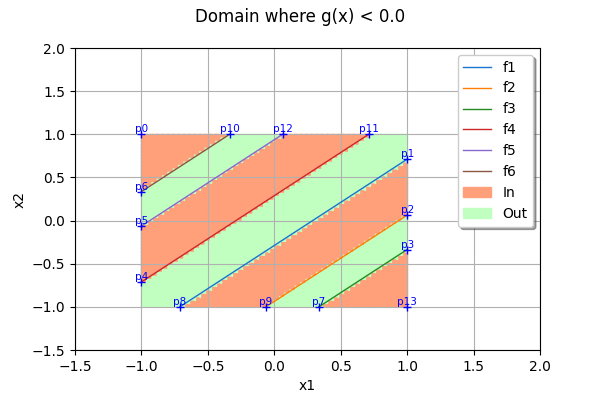

In [39]:
domain.add(text)
domain

The probability is the ratio between the failure domain and the domain itself. The area of the domain is $2^2$. The area of each polygon is computed based on the shapely module.

In [40]:
corners = np.array([sample[i] for i in [0, 6, 10]])
corners

array([[-1.        ,  1.        ],
       [-1.        ,  0.33553391],
       [-0.33553391,  1.        ]])

In [41]:
polygon = Polygon(corners)
area1 = polygon.area
area1

0.2207575950825023

In [42]:
corners = np.array([sample[i] for i in [4, 11, 12, 5]])
corners
polygon = Polygon(corners)
area2 = polygon.area
area2

0.8992712614902384

In [43]:
corners = np.array([sample[i] for i in [8, 9, 2, 1]])
corners
polygon = Polygon(corners)
area3 = polygon.area
area3

0.8992712614902386

In [44]:
corners = np.array([sample[i] for i in [7, 13, 3]])
corners
polygon = Polygon(corners)
area4 = polygon.area
area4

0.2207575950825023

In [45]:
pf = (area1 + area2 + area3 + area4) / 2.0 ** 2
pf

0.5600144282863704

In [46]:
print("pf=%.17e" % (pf))

pf=5.60014428286370380e-01
